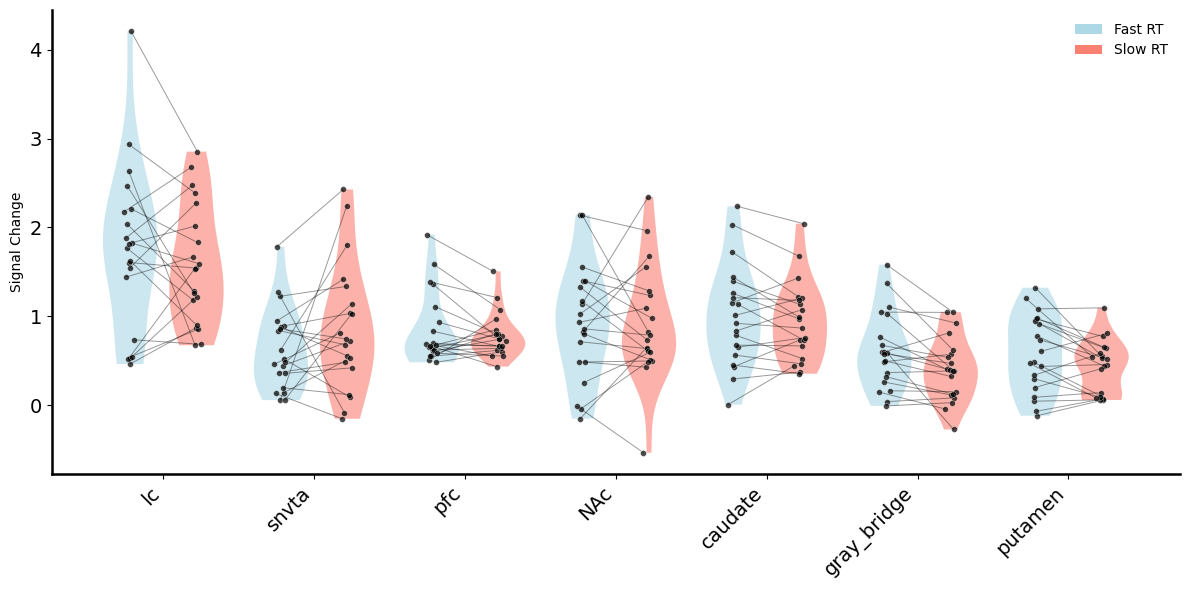

In [11]:
# %% Load source data and reproduce Fig 3 RT violin+slope
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch

in_xlsx = os.path.join(data_dir, "output", "SourceData_Fig3_SH_RT.xlsx")

roi_order = ["lc", "snvta", "pfc", "NAc", "caudate", "gray_bridge", "putamen"]
FAST_LABEL, SLOW_LABEL = "Fast RT", "Slow RT"

df_wide_in = pd.read_excel(in_xlsx, sheet_name="SourceData_Wide")

# reconstruct per-ROI subject arrays from the wide table
all_roi_fast_subject = [df_wide_in[f"Fast_{r}"].to_numpy(dtype=float) for r in roi_order]
all_roi_slow_subject = [df_wide_in[f"Slow_{r}"].to_numpy(dtype=float) for r in roi_order]

# optional: compute mean±SEM for y-limit similar to your earlier logic
means = np.array([[np.nanmean(f), np.nanmean(s)] for f, s in zip(all_roi_fast_subject, all_roi_slow_subject)])
sems  = np.array([[np.nanstd(f, ddof=1)/np.sqrt(np.isfinite(f).sum()),
                   np.nanstd(s, ddof=1)/np.sqrt(np.isfinite(s).sum())]
                  for f, s in zip(all_roi_fast_subject, all_roi_slow_subject)])
max_y = np.nanmax(means + sems)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_order))
offset = 0.22
vwidth = 0.36
JITTER_SD = 0.02

fast_color, slow_color = "lightblue", "salmon"

for i, r in enumerate(roi_order):
    fast = np.asarray(all_roi_fast_subject[i], float)
    slow = np.asarray(all_roi_slow_subject[i], float)

    # violins
    parts = ax.violinplot([fast, slow],
                          positions=[x[i] - offset, x[i] + offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts["bodies"][0].set_facecolor(fast_color); parts["bodies"][0].set_alpha(0.6); parts["bodies"][0].set_edgecolor("none")
    parts["bodies"][1].set_facecolor(slow_color); parts["bodies"][1].set_alpha(0.6); parts["bodies"][1].set_edgecolor("none")

    # paired slope + points (same jitter for each subject)
    mask = np.isfinite(fast) & np.isfinite(slow)
    fast_p = fast[mask]
    slow_p = slow[mask]

    rng = np.random.default_rng(7 + i)  # ROI-specific seed
    base = rng.normal(0, JITTER_SD, size=fast_p.size)

    x_fast = x[i] - offset + base
    x_slow = x[i] + offset + base

    for xf, xs, yf, ys in zip(x_fast, x_slow, fast_p, slow_p):
        ax.plot([xf, xs], [yf, ys], color="k", alpha=0.4, lw=0.7, zorder=4)

    ax.scatter(x_fast, fast_p, s=18, alpha=0.7, color="k", linewidth=0.3, edgecolor="white", zorder=5)
    ax.scatter(x_slow, slow_p, s=18, alpha=0.7, color="k", linewidth=0.3, edgecolor="white", zorder=5)

# style
ax.set_xticks(x)
ax.set_xticklabels(roi_order, rotation=45, ha="right")
ax.set_ylabel("Signal Change")
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.8)
ax.spines["bottom"].set_linewidth(1.8)
ax.legend(handles=[Patch(facecolor=fast_color, label=FAST_LABEL),
                   Patch(facecolor=slow_color, label=SLOW_LABEL)],
          frameon=False, loc="upper right")

plt.tight_layout()
out_png = os.path.join(data_dir, "output", "roi_rt_violin_slope_from_source.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight")